# Forecasting with a Prophet 📉

**Ressource**

https://neuralprophet.com/

**Ancienne**

https://youtu.be/pOYAXv15r3A

One piece of recent open software is facebook's `prophet`. This uses a model which is similar to a **generalised additive model** (GAM), a class of additive (linear) models with potentially non-linear components. 

The model is easily interpreted (as a sum of components) and simple to fit (parameters have a strightforward interpretation).
But if the hypothesis of the parametric model are not respected, the fitted model may seriously underfit.

You can read more about the underlying model [here](https://peerj.com/preprints/3190/).

As you are beginning to see time series forecasting can sometimes be as much an art as a science, and we know it takes quite some practice to become a good artist. The authors of the software had this in mind when they wrote it.  One of their aims is to provide software which can be used easily by those who have a little timeseries knowledge. Let's see how this goes....We will apply this software to the airline data now.

To install prophet I advise you to install a completely clean virtualenvironment with conda (you will find the instructions to do this [here](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-environments.html)).

Then you can install prophet with: `conda install -c conda-forge fbprophet`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns 
import matplotlib.style as style

# Example 1 - airline data

We setup the data as we had done so before in the ARIMA example.

In [2]:
from pmdarima.datasets import load_airpassengers

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, 
                             periods=len(airline), 
                             freq='MS')

In [3]:
def ts_train_val_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [4]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month

train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model


## Forecasting with prophet

Fitting a basic model and making predictions is very simple with `prophet`.

In [5]:
from neuralprophet import NeuralProphet
pd.plotting.register_matplotlib_converters()

/home/alexandra.lamotte@Digital-Grenoble.local/miniconda3/envs/ML6/lib/python3.9/site-packages/plotly_resampler/aggregation/aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


Training data is expected in this df format below.

In [14]:
train_df = pd.DataFrame(train).reset_index().rename(columns = {0:'y','index':'ds'})

test_df = pd.DataFrame(test).reset_index().rename(columns = {0:'y','index':'ds'})

In [7]:
train_df.tail()

,ds,y
127,1959-08-01,18.032258
128,1959-09-01,15.433333
129,1959-10-01,13.129032
130,1959-11-01,12.066667
131,1959-12-01,13.064516


Fit model...

In [56]:
m = NeuralProphet(quantiles=[0.05, 0.95]) #quantiles = incertitude
# m.set_plotting_backend("plotly-static")  # show plots correctly in jupyter notebooks
metrics = m.fit(train_df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.242]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 456
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (9) is too small than the required number for the learning rate finder (209). The results

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [57]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,11.193320,12.707301,0.699287,0.0,0
1,11.189721,12.527103,0.680533,0.0,1
2,11.770030,13.029879,0.745166,0.0,2
3,10.552742,11.669701,0.643795,0.0,3
4,11.244462,12.582118,0.672838,0.0,4
...,...,...,...,...,...
451,0.497391,0.634922,0.001384,0.0,451
452,0.501619,0.647274,0.001434,0.0,452
453,0.486630,0.613327,0.001334,0.0,453
454,0.499532,0.633789,0.001388,0.0,454


Make predictions...

In [58]:
predicted = m.predict(train_df)
forecast = m.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.242]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.242]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 9it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 9it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [59]:
predicted

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly
0,1949-01-01,3.612903,2.330340,2.190978,3.377216,3.333708,-1.003368
1,1949-02-01,4.214286,2.933729,2.719771,4.048989,3.449680,-0.515951
2,1949-03-01,4.258065,3.436102,3.151885,4.423094,3.554429,-0.118326
3,1949-04-01,4.300000,3.510086,3.118586,4.525022,3.670401,-0.160314
4,1949-05-01,3.903226,3.445357,3.106430,4.412516,3.782631,-0.337274
...,...,...,...,...,...,...,...
127,1959-08-01,18.032258,16.107702,14.793709,17.516726,14.046257,2.061443
128,1959-09-01,15.433333,14.854731,14.155127,15.677664,14.133072,0.721660
129,1959-10-01,13.129032,13.272320,12.511408,13.971077,14.217085,-0.944766
130,1959-11-01,12.066667,12.454205,11.467087,13.342684,14.303898,-1.849694


In [60]:
forecast

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly
0,1960-01-01,13.451613,13.477577,12.636993,14.316744,14.474724,-0.997147
1,1960-02-01,13.482759,14.021637,13.070080,14.997953,14.561539,-0.539902
2,1960-03-01,13.516129,14.523722,13.570980,15.370733,14.642752,-0.119030
3,1960-04-01,15.366667,14.568579,13.584526,15.446236,14.729565,-0.160986
4,1960-05-01,15.225806,14.479109,13.565071,15.342869,14.813580,-0.334470
5,1960-06-01,17.833333,16.221458,15.212288,17.410540,14.900393,1.321067
6,1960-07-01,20.064516,17.125719,15.576664,18.561184,14.984406,2.141314
7,1960-08-01,19.548387,17.128595,15.713053,18.687717,15.071218,2.057379
8,1960-09-01,16.933333,15.825115,14.923319,16.838348,15.158031,0.667083
9,1960-10-01,14.870968,14.271179,13.388411,15.130888,15.242044,-0.970866


In [61]:
# future = model.make_future_dataframe(periods=12, 
#                                      freq='MS', 
#                                      include_history=True) 
# #create a dataframe with the prediction datetimes we want
# future.head()

future = m.make_future_dataframe(test_df, periods=24)
future

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y
0,1961-01-01,None
1,1961-02-01,None
2,1961-03-01,None
3,1961-04-01,None
4,1961-05-01,None
5,1961-06-01,None
6,1961-07-01,None
7,1961-08-01,None
8,1961-09-01,None
9,1961-10-01,None


In [62]:
forecast2 = m.predict(future)
# y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
forecast2

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 9it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly
0,1961-01-01,None,14.496317,13.449438,15.542822,15.499685,-1.003368
1,1961-02-01,None,15.070547,13.996510,16.202974,15.586500,-0.515951
2,1961-03-01,None,15.546585,14.445135,16.566584,15.664911,-0.118326
3,1961-04-01,None,15.591412,14.430117,16.656891,15.751726,-0.160314
4,1961-05-01,None,15.498465,14.435652,16.533140,15.835739,-0.337274
5,1961-06-01,None,17.226387,16.042709,18.600698,15.922552,1.303833
6,1961-07-01,None,18.149601,16.456507,19.754896,16.006565,2.143035
7,1961-08-01,None,18.152222,16.553499,19.901331,16.093380,2.058842
8,1961-09-01,None,16.865473,15.814127,18.055182,16.180193,0.685280
9,1961-10-01,None,15.302000,14.242870,16.347990,16.264206,-0.962206


Plot predictions...

In [63]:
predicted

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly
0,1949-01-01,3.612903,2.330340,2.190978,3.377216,3.333708,-1.003368
1,1949-02-01,4.214286,2.933729,2.719771,4.048989,3.449680,-0.515951
2,1949-03-01,4.258065,3.436102,3.151885,4.423094,3.554429,-0.118326
3,1949-04-01,4.300000,3.510086,3.118586,4.525022,3.670401,-0.160314
4,1949-05-01,3.903226,3.445357,3.106430,4.412516,3.782631,-0.337274
...,...,...,...,...,...,...,...
127,1959-08-01,18.032258,16.107702,14.793709,17.516726,14.046257,2.061443
128,1959-09-01,15.433333,14.854731,14.155127,15.677664,14.133072,0.721660
129,1959-10-01,13.129032,13.272320,12.511408,13.971077,14.217085,-0.944766
130,1959-11-01,12.066667,12.454205,11.467087,13.342684,14.303898,-1.849694


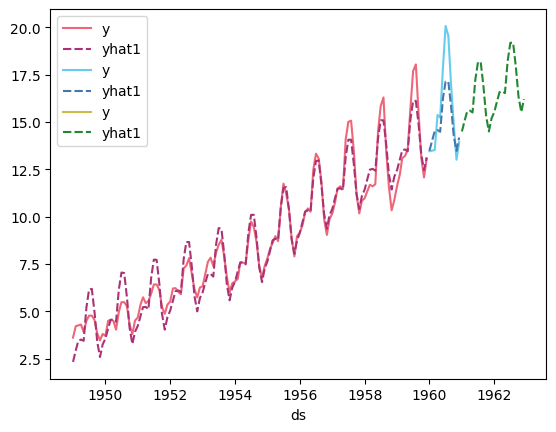

In [74]:
import matplotlib.pyplot as plt
import seaborn.objects as so
# fig, axs=plt.subplots(ncols=3)

# m.plot(predicted, plotting_backend="matplotlib")
# m.plot(forecast, plotting_backend="matplotlib")
# m.plot(forecast2, plotting_backend="matplotlib")

import seaborn as sns
sns.lineplot(predicted.loc[:,['ds', 'y', 'yhat1']].set_index(keys='ds'), palette=['#EE6677', '#AA3377'])
sns.lineplot(forecast.loc[:,['ds', 'y', 'yhat1']].set_index(keys='ds'), palette=['#66CCEE', '#4477AA'])
sns.lineplot(forecast2.loc[:,['ds', 'y', 'yhat1']].set_index(keys='ds'), palette=['#CCBB44', '#228833'])
plt.show()


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


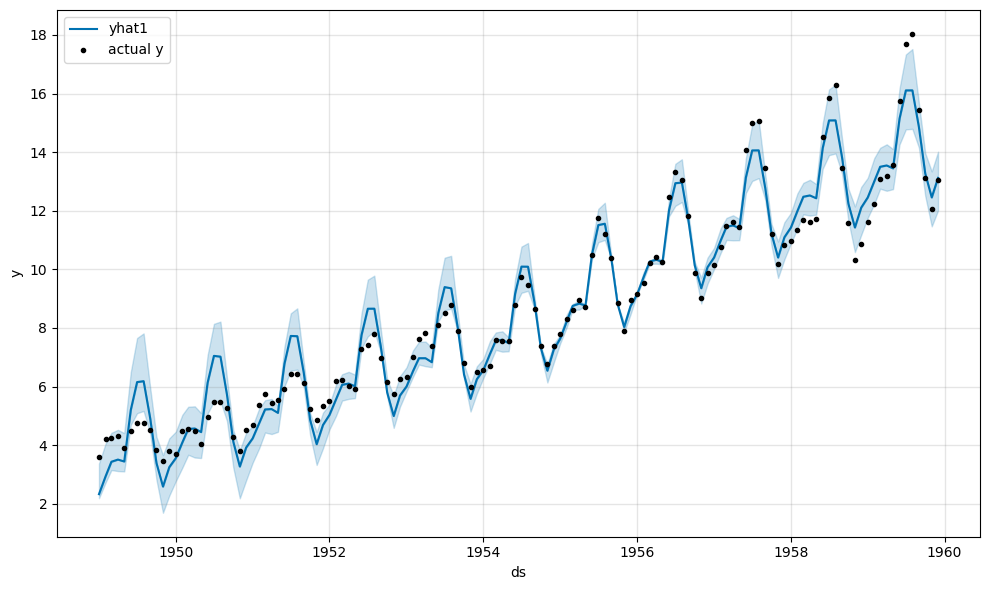

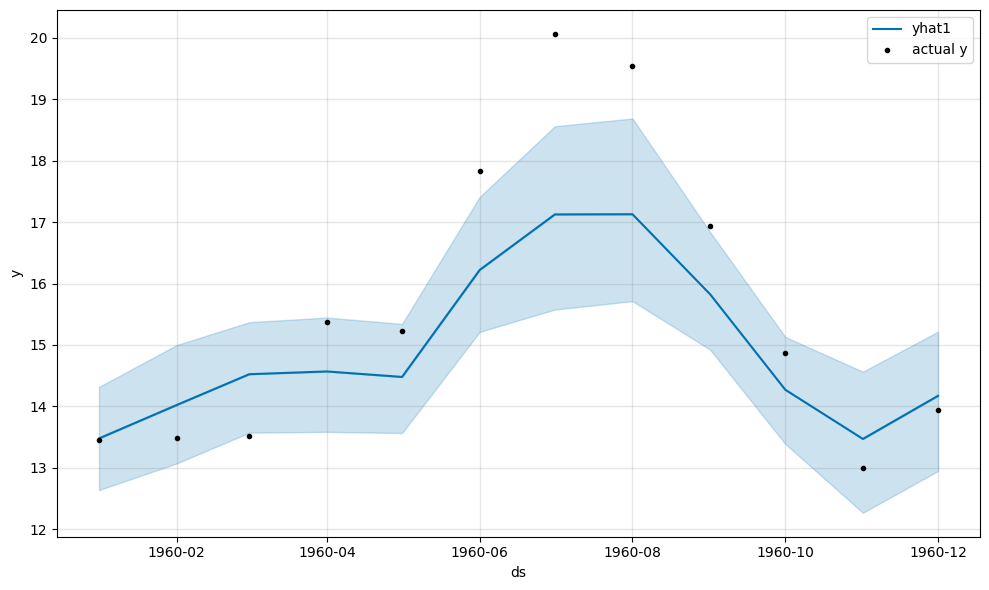

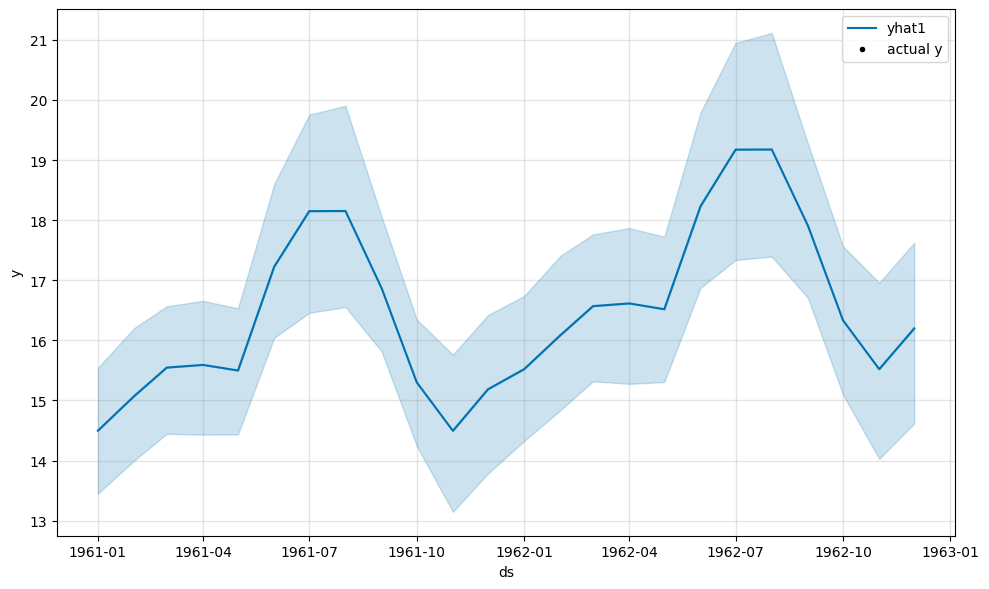

In [75]:
m.plot(predicted, plotting_backend="matplotlib")
m.plot(forecast, plotting_backend="matplotlib")
m.plot(forecast2, plotting_backend="matplotlib")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


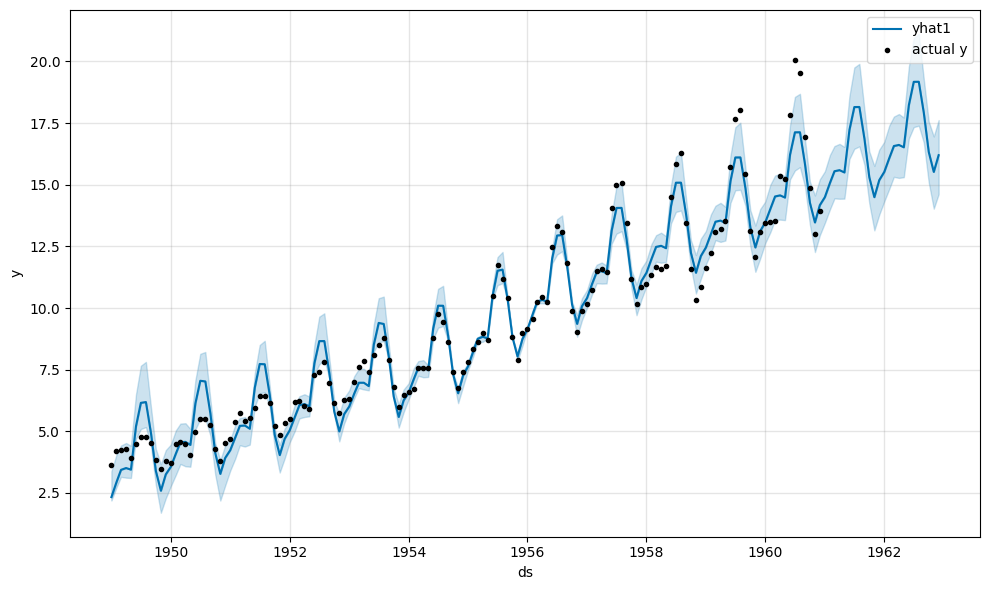

In [77]:
df_concat = pd.concat([predicted, forecast, forecast2], axis=0)
m.plot(df_concat, plotting_backend="matplotlib")


In [40]:
# fig = model.plot(forecast)
# test.plot(style='.r')

Evaluating this baseline model error on test set...

In [78]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [79]:
forecast

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly
0,1960-01-01,13.451613,13.477577,12.636993,14.316744,14.474724,-0.997147
1,1960-02-01,13.482759,14.021637,13.070080,14.997953,14.561539,-0.539902
2,1960-03-01,13.516129,14.523722,13.570980,15.370733,14.642752,-0.119030
3,1960-04-01,15.366667,14.568579,13.584526,15.446236,14.729565,-0.160986
4,1960-05-01,15.225806,14.479109,13.565071,15.342869,14.813580,-0.334470
5,1960-06-01,17.833333,16.221458,15.212288,17.410540,14.900393,1.321067
6,1960-07-01,20.064516,17.125719,15.576664,18.561184,14.984406,2.141314
7,1960-08-01,19.548387,17.128595,15.713053,18.687717,15.071218,2.057379
8,1960-09-01,16.933333,15.825115,14.923319,16.838348,15.158031,0.667083
9,1960-10-01,14.870968,14.271179,13.388411,15.130888,15.242044,-0.970866


In [80]:
mean_absolute_percentage_error(test.values , 
                               forecast['yhat1'][-12:])

6.140948036190999

We at least see it beats the naive model scores  that we saw in the last notebook (from the unlogged data). Not bad for only several lines of code. But looking at the plot it is clearly not fitting well. We should use cross validation to find a better fitting model (before we evaluated in the test set!).

## Cross validation in prophet

There are cross validation functions in `prophet` that take care of time series data and can perform adjustable rolling windows as we had previously seen in other time series cross validation functions.

In [52]:
# from fbprophet.diagnostics import cross_validation
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.plot import plot_cross_validation_metric

In [53]:
365.25*4

1461.0

In [139]:
# from torchmetrics.metric import MeanAbsolutePercentageError, SymmetricMeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, SymmetricMeanAbsolutePercentageError

# model = Prophet()
metrics_wanted={"MAPE": MeanAbsolutePercentageError(),"SMAPE":SymmetricMeanAbsolutePercentageError(),  "MAE":MeanAbsoluteError(), "RMSE":MeanSquaredError(squared=True)}
m = NeuralProphet(seasonality_mode="multiplicative", quantiles=[0.05,0.95], collect_metrics=metrics_wanted)
list_cv = m.crossvalidation_split_df(train_df, k=5)


# train0, val0 = list_cv[0]
# train1, val1 = list_cv[1]
# train2, val2 = list_cv[2]
# train3, val3 = list_cv[3]
# train4, val4 = list_cv[4]


# metrics_0 = m.fit(train0, progress=None)
# metrics_val_0 = m.test(val0)
# metrics_row_0 = pd.DataFrame(metrics_0.iloc[-1]).T
# metrics_val_row_0 = pd.DataFrame(metrics_val_0.iloc[-1]).T


metrics_all = pd.DataFrame()
metrics_val_all = pd.DataFrame()

for train_current, val_current in list_cv:
# for i in range(len(list_cv)):
#     train_current, val_current = list_cv[i]
    m = NeuralProphet(seasonality_mode="multiplicative", quantiles=[0.05,0.95], collect_metrics=metrics_wanted)

    metrics_current = m.fit(train_current, progress=None)
    metrics_val_current = m.test(val_current)

    metrics_row_current = pd.DataFrame(metrics_current).iloc[-1].T
    metrics_val_row_current = pd.DataFrame(metrics_val_current).iloc[-1].T

    metrics_all = pd.concat([metrics_all, metrics_row_current], axis=1)
    metrics_val_all = pd.concat([metrics_val_all,metrics_val_row_current ], axis=1)

list_cv_names_train = [f'cv_{i}' for i in range(len(list_cv))]
list_cv_names_val = [f'cv_val_{i}' for i in range(len(list_cv))]
metrics_final = pd.concat([
    metrics_all.set_axis(list_cv_names_train, axis=1).T.reset_index().drop(columns='index'), 
    metrics_val_all.set_axis(list_cv_names_val, axis=1).T.reset_index().drop(columns='index')
    ], axis=1).reset_index(names=['cv'])
metrics_final

metrics_final_mean_std = metrics_final.describe().loc[["mean", "std"]].drop(columns=['cv'])
metrics_final_mean_std


# df_cv = cross_validation(model, 
#                          initial='1461 days', 
#                          period='365 days', 
#                          horizon = '365 days')
# metrics

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.242]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.901]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 572
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number for the learning rate finder (207). The results might not be optimal.


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [92.308]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.98]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epo

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.001735733705572784
         MAE_val            0.2847309708595276
        MAPE_val            0.02415083907544613
        RMSE_val            0.1022401675581932
      RegLoss_test                  0.0
        SMAPE_val           0.02394728548824787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [92.308]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.048]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set ep

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.004690422210842371
         MAE_val            0.4182221293449402
        MAPE_val            0.03528990596532822
        RMSE_val            0.32675689458847046
      RegLoss_test                  0.0
        SMAPE_val           0.03423861414194107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [92.308]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.107]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set ep

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.007670446299016476
         MAE_val            0.8235229849815369
        MAPE_val             0.065371572971344
        RMSE_val            0.9147614240646362
      RegLoss_test                  0.0
        SMAPE_val           0.06281498074531555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [92.308]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.16]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epo

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0032311941031366587
         MAE_val            0.5673234462738037
        MAPE_val            0.04448555409908295
        RMSE_val             0.422923743724823
      RegLoss_test                  0.0
        SMAPE_val          0.043244440108537674
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [92.308]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.002531415084376931
         MAE_val            0.4595406651496887
        MAPE_val           0.033785395324230194
        RMSE_val            0.32830461859703064
      RegLoss_test                  0.0
        SMAPE_val           0.03456909954547882
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,MAPE,RMSE,SMAPE,Loss,RegLoss,epoch,MAE_val,MAPE_val,RMSE_val,SMAPE_val,Loss_test,RegLoss_test
mean,0.201614,0.034424,0.064701,0.034056,0.000391,0.0,524.400000,0.510668,0.040617,0.418997,0.039763,0.003972,0.0
std,0.019502,0.002491,0.012652,0.002327,0.000058,0.0,34.428186,0.202049,0.015604,0.301192,0.014587,0.002336,0.0


In [152]:
# df_cv.head()

A function for performance metrics and plotting...

In [170]:
# df_p = performance_metrics(df_cv)
#aller voir : https://facebook.github.io/prophet/docs/diagnostics.html 

# horizon = nb of point of val_df of each cross val
horizon = [6, 12, 18, 24] #in month

# len(train_df) 
#on va fit le model sur train_df.iloc[:132-24] puis évaluer nos métriques sur des datasets de test de + en + grand 
index_max_train = len(train_df)-np.max(horizon)
sub_train = train_df.iloc[:index_max_train]
# sub_train #108
metrics_wanted={"MAPE": MeanAbsolutePercentageError(),"SMAPE":SymmetricMeanAbsolutePercentageError(),  "MAE":MeanAbsoluteError(), "RMSE":MeanSquaredError(squared=True)}
m = NeuralProphet(seasonality_mode="multiplicative", quantiles=[0.05,0.95], collect_metrics=metrics_wanted)
metrics = m.fit(sub_train)
metrics_train = metrics.iloc[-1].T


metrics_performance = pd.DataFrame()

for horizon_current in horizon :
    index_max_val =index_max_train+horizon_current
    sub_val = train_df.iloc[index_max_train:index_max_val]
    # print(len(sub_val))
    metrics_val = m.test(sub_val)
    metrics_val_row = pd.DataFrame(metrics_val.iloc[-1]).T.assign(horizon=f'{len(sub_val)} month')

    metrics_performance = pd.concat([metrics_performance, metrics_val_row], axis=0)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.074]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 514
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (7) is too small than the required number for the learning rate finder (207). The results

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [83.333]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Testing: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.012591416947543621
         MAE_val            1.0359039306640625
        MAPE_val            0.08597850799560547
        RMSE_val            1.2423396110534668
      RegLoss_test                  0.0
        SMAPE_val           0.08192313462495804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [94.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.011444373987615108
         MAE_val            0.9844415783882141
        MAPE_val            0.07928482443094254
        RMSE_val            1.1330753564834595
      RegLoss_test                  0.0
        SMAPE_val           0.0757923349738121
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.012226443737745285
         MAE_val            1.0283620357513428
        MAPE_val            0.08074962347745895
        RMSE_val            1.2123193740844727
      RegLoss_test                  0.0
        SMAPE_val           0.07722911238670349
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.010589833371341228
         MAE_val            0.9160564541816711
        MAPE_val            0.06958829611539841
        RMSE_val             1.050093650817871
      RegLoss_test                  0.0
        SMAPE_val            0.066709004342556
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [171]:
metrics_performance

,MAE_val,MAPE_val,RMSE_val,SMAPE_val,Loss_test,RegLoss_test,horizon
0,1.035904,0.085979,1.242340,0.081923,0.012591,0.0,6 month
0,0.984442,0.079285,1.133075,0.075792,0.011444,0.0,12 month
0,1.028362,0.080750,1.212319,0.077229,0.012226,0.0,18 month
0,0.916056,0.069588,1.050094,0.066709,0.010590,0.0,24 month


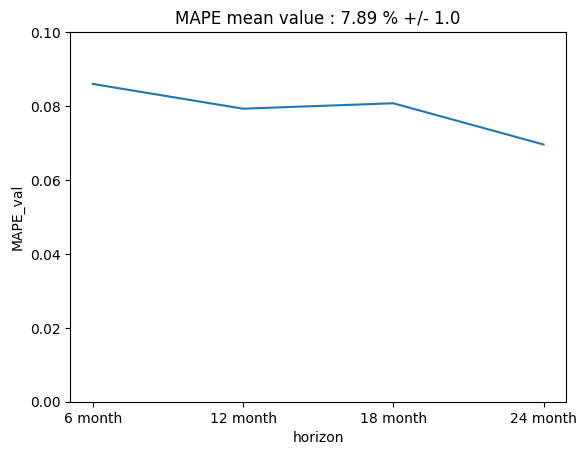

In [182]:
mean_mape_all_horizons = metrics_performance.MAPE_val.mean()
std_mape_all_horizons =  metrics_performance.MAPE_val.std()
sns.lineplot(x=metrics_performance.horizon, y=metrics_performance.MAPE_val)
plt.title(f'MAPE mean value : {round(mean_mape_all_horizons,4)*100} % +/- {round(std_mape_all_horizons,2)*100}')
plt.ylim(0, 0.1)
plt.show()

In [57]:
# df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,61 days,0.731749,0.855423,0.708125,0.079015,0.071685,0.380952
1,62 days,0.900625,0.949012,0.825101,0.085354,0.086172,0.285714
2,89 days,0.744382,0.862776,0.713703,0.075617,0.086172,0.333333
3,90 days,0.574954,0.758257,0.584116,0.054702,0.041338,0.571429
4,120 days,0.471565,0.686706,0.544250,0.054785,0.050609,0.500000


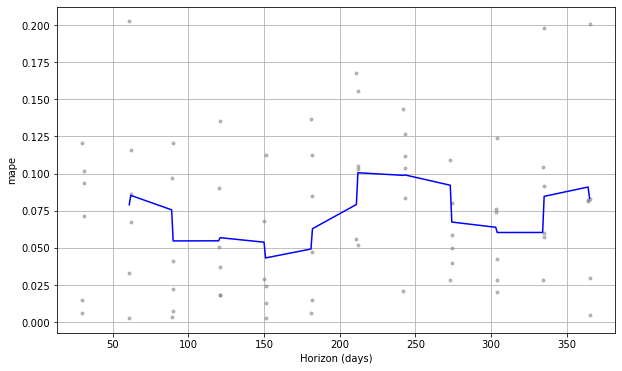

In [58]:
# fig = plot_cross_validation_metric(df_cv, metric='mape')
# plt.show()

The plot above is the standard output plot of the CV from `prophet`. It is different to what we have looked at before. Each grey point represents a prediction, made on a particular month. Because we made predictions over several horizons each are plotted on the graph. At around horizon 30 for example we see each of the plots over the first month of each of the 6, 12 month validations. The blue line shows a rolling window of the mape scores 'averaged' over the cv predictions. More info [here](https://facebook.github.io/prophet/docs/diagnostics.html).

We are normally interested in the mean and std of the MAPE scores found at each window. This can be calculated from the dataframe returned from the `cross_validation` function above, using the function below. 

In [59]:
def mape_performance_calc(df_cv):
    " function to replace prophet cv 'performance metrics' function"
    df_cv['mape'] = abs(df_cv['y'] - df_cv['yhat']) /df_cv['y'] # make column with individual abs normalised values
    results = df_cv.groupby(['cutoff']).mean() # finish mape calc for each of the folds (distinguised in 'cutoff' column of df_cv)
    results = results.describe() # sumarise folds information
    results = results['mape']# # return only mape column
    return(results)

mape_performance_calc(df_cv)

count    6.000000
mean     0.072154
std      0.020667
min      0.052698
25%      0.059283
50%      0.066481
75%      0.077062
max      0.109789
Name: mape, dtype: float64

We find a MAPE of ~7.2% with std ~2%. This would have estimated the error we saw on the test set to a good degree.

## Hyper-parameters

The model plot we saw earlier did not fit very well to the train data. We can change the model assumptions (like hyper-parameters) to change how well it is fitting the train data.

`Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)`

**class neuralprophet.forecaster.NeuralProphet**
(
    
    growth: Literal['off', 'linear', 'discontinuous'] = 'linear',   
    changepoints: Optional[list] = None,  
    n_changepoints: int = 10,  
    changepoints_range: float = 0.8,  
    trend_reg: float = 0,  
    trend_reg_threshold: Optional[Union[bool, float]] = False,  
    trend_global_local: str = 'global',  
    > yearly_seasonality: Union[Literal['auto'], bool, int] = 'auto',  
    > weekly_seasonality: Union[Literal['auto'], bool, int] = 'auto',   
    > daily_seasonality: Union[Literal['auto'], bool, int] = 'auto',  
    > seasonality_mode: Literal['additive', 'multiplicative'] = 'additive', 
    seasonality_reg: float = 0, 
    season_global_local: Literal['global', 'local'] = 'global', 
    > n_forecasts: int = 1, 
    > n_lags: int = 2, 
    ar_layers: Optional[list] = [], 
    ar_reg: Optional[float] = None, 
    lagged_reg_layers: Optional[list] = [], 
    learning_rate: Optional[float] = None, 
    epochs: Optional[int] = None, 
    batch_size: Optional[int] = None, 
    loss_func: Union[str, torch.nn.modules.loss._Loss, Callable] = 'Huber', 
    optimizer: Union[str, Type[torch.optim.optimizer.Optimizer]] = 'AdamW', 
    newer_samples_weight: float = 2, 
    newer_samples_start: float = 0.0, 
    quantiles: List[float] = [], 
    impute_missing: bool = True, 
    impute_linear: int = 10, 
    impute_rolling: int = 10, 
    drop_missing: bool = False, 
    > collect_metrics: Union[bool, list, dict] = True, 
    normalize: Literal['auto', 'soft', 'soft1', 'minmax', 'standardize', 'off'] = 'auto', 
    global_normalization: bool = False, 
    global_time_normalization: bool = True, 
    unknown_data_normalization: bool = False, 
    accelerator: Optional[str] = None, 
    trainer_config: dict = {}, 
    prediction_frequency: Optional[dict] = None
)

**TASK**

* Try changing some of these. [This](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) blog is very useful in explaining the parameters and what they do.
* Find at least one change which improves your model cross validation score

In [183]:
#### your solution here 
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, SymmetricMeanAbsolutePercentageError


metrics_wanted={"MAPE": MeanAbsolutePercentageError(),"SMAPE":SymmetricMeanAbsolutePercentageError(),  "MAE":MeanAbsoluteError(), "RMSE":MeanSquaredError(squared=True)}
m = NeuralProphet(seasonality_mode="multiplicative", quantiles=[0.05,0.95], collect_metrics=metrics_wanted , yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, n_lags=2)
list_cv = m.crossvalidation_split_df(train_df, k=5)




metrics_all = pd.DataFrame()
metrics_val_all = pd.DataFrame()

for train_current, val_current in list_cv:
    m = NeuralProphet(seasonality_mode="multiplicative", quantiles=[0.05,0.95], collect_metrics=metrics_wanted, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, n_lags=2)

    metrics_current = m.fit(train_current, progress=None)
    metrics_val_current = m.test(val_current)

    metrics_row_current = pd.DataFrame(metrics_current).iloc[-1].T
    metrics_val_row_current = pd.DataFrame(metrics_val_current).iloc[-1].T

    metrics_all = pd.concat([metrics_all, metrics_row_current], axis=1)
    metrics_val_all = pd.concat([metrics_val_all,metrics_val_row_current ], axis=1)

list_cv_names_train = [f'cv_{i}' for i in range(len(list_cv))]
list_cv_names_val = [f'cv_val_{i}' for i in range(len(list_cv))]
metrics_final = pd.concat([
    metrics_all.set_axis(list_cv_names_train, axis=1).T.reset_index().drop(columns='index'), 
    metrics_val_all.set_axis(list_cv_names_val, axis=1).T.reset_index().drop(columns='index')
    ], axis=1).reset_index(names=['cv'])
metrics_final

metrics_final_mean_std = metrics_final.describe().loc[["mean", "std"]].drop(columns=['cv'])
metrics_final_mean_std





INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.242]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.901]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 580
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number for the learning rate finder (207). The results might not be optimal.


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [93.333]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.98]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 553
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number for the learning rate finder (207). The results might not be optimal.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01072738692164421
         MAE_val            0.6853076219558716
        MAPE_val            0.05973954498767853
        RMSE_val            0.8659519553184509
      RegLoss_test                  0.0
        SMAPE_val          0.058772068470716476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [93.333]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.048]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 529
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (7) is too small than the required number for the learning rate finder (207). The results might not be optimal.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0030361462850123644
         MAE_val            0.36054033041000366
        MAPE_val            0.03076641820371151
        RMSE_val            0.1940697729587555
      RegLoss_test                  0.0
        SMAPE_val          0.030248213559389114
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [93.333]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.107]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 508
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (7) is too small than the required number for the learning rate finder (208). The results might not be optimal.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0030258693732321262
         MAE_val            0.3924154043197632
        MAPE_val            0.03031834214925766
        RMSE_val            0.2753496766090393
      RegLoss_test                  0.0
        SMAPE_val          0.030111592262983322
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [93.333]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.16]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 489
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (8) is too small than the required number for the learning rate finder (208). The results might not be optimal.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.006483890116214752
         MAE_val            0.4252283275127411
        MAPE_val            0.03215084969997406
        RMSE_val            0.2798392176628113
      RegLoss_test                  0.0
        SMAPE_val           0.03192909434437752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [93.333]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0052788439206779
         MAE_val            0.7522948384284973
        MAPE_val           0.052880994975566864
        RMSE_val            0.7733427882194519
      RegLoss_test                  0.0
        SMAPE_val           0.05274117738008499
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,MAPE,RMSE,SMAPE,Loss,RegLoss,epoch,MAE_val,MAPE_val,RMSE_val,SMAPE_val,Loss_test,RegLoss_test
mean,0.283315,0.043472,0.147472,0.043808,0.001035,0.0,530.80000,0.523157,0.041171,0.477711,0.040760,0.005710,0.0
std,0.090779,0.012782,0.104963,0.013141,0.000729,0.0,35.98194,0.181607,0.014047,0.315707,0.013873,0.003175,0.0


# Exercise 1 - energy data forecasting ⚡

Forecasting energy demand is big business and very important in helping energy producers maintain the balance within the electrical grid. You can find forecasts of energy demands for France in realtime [here](https://www.rte-france.com/fr/eco2mix/eco2mix-consommation). The data was already downloaded in the `data/nats.csv` file.

Your mission now is to imagine a useful use-case for an enterprise and use `Prophet` to make forecasts on the energy data you have already seen (in data viz module) for France! Feel free to choose :
* the type of energy generation/consommation
* france or regional,
* frequency scale you wish to try!

Try and consider a forecast horizon that seems useful for the frequency at which you are making your predictions e.g. predicting the hourly forecast for 12 months propbably cannot be used in any meaningful way - and is probably not going be very easy to forecast accurately.

Consider that:
* Reducing the scale of the data, i.e. to regional
* Higher frequency predictions
* longer periods of forecast

...are likely to make it more difficult to make a good forecast.

Consider also that you must pick the most suitable cross validation procedure for your problem. Consider the initial, step and horizon you will use carefully.

Once you have made your model:
1. Compare it to a naive model!! If it does not beat this then try reducing your forecast horizon to find at what scale you can make useful predictions.
2. Try tuning the model in some way to improve performance (add holidays might be a good idea)
3. If you have time compare your model to an ARIMA model. Why might there be differences in perfomance between the two approachecs to forecasting?

(feel free to use a new notebook for this task!)

In [191]:
train_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [205]:
#à partir de df_nat dans drive/Dataviz/data

df = (pd.read_csv('../data/df_nat.csv')
      .dropna()
      .assign(DateTime=lambda df : df.DateTime.astype('datetime64'))
      .resample('7D', on='DateTime').sum()
      .reset_index().loc[:,['DateTime', 'Consommation']]
      .set_axis(labels=['ds', 'y'], axis=1)
      .iloc[:364,:])
# df.dtypes
display(df)
#y=Consommation totale par semaine



,ds,y
0,2012-01-01,21568498.0
1,2012-01-08,22766032.0
2,2012-01-15,24291111.0
3,2012-01-22,22268420.0
4,2012-01-29,27262261.0
...,...,...
359,2018-11-18,22466620.0
360,2018-11-25,21480451.0
361,2018-12-02,19872991.0
362,2018-12-09,23162703.0


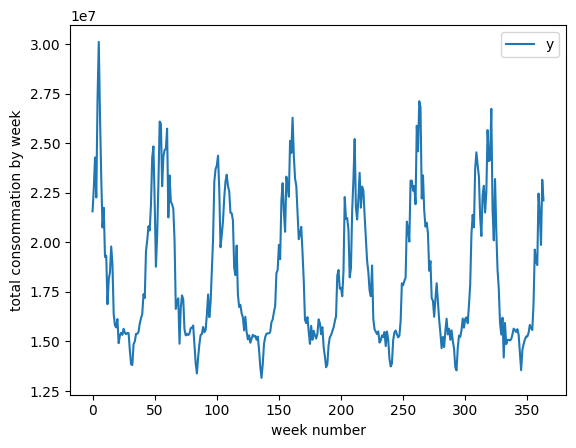

In [207]:
sns.lineplot(df).set(xlabel='week number', ylabel='total consommation by week')
plt.show()

In [208]:
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, SymmetricMeanAbsolutePercentageError


metrics_wanted={"MAPE": MeanAbsolutePercentageError(),"SMAPE":SymmetricMeanAbsolutePercentageError(),  "MAE":MeanAbsoluteError(), "RMSE":MeanSquaredError(squared=True)}

m = NeuralProphet(seasonality_mode="additive", quantiles=[0.05,0.95], collect_metrics=metrics_wanted)

train, test = m.split_df(df)


list_cv = m.crossvalidation_split_df(train, k=5)




metrics_all = pd.DataFrame()
metrics_val_all = pd.DataFrame()

for train_current, val_current in list_cv:
    m = NeuralProphet(seasonality_mode="additive", quantiles=[0.05,0.95], collect_metrics=metrics_wanted)

    metrics_current = m.fit(train_current, progress=None)
    metrics_val_current = m.test(val_current)

    metrics_row_current = pd.DataFrame(metrics_current).iloc[-1].T
    metrics_val_row_current = pd.DataFrame(metrics_val_current).iloc[-1].T

    metrics_all = pd.concat([metrics_all, metrics_row_current], axis=1)
    metrics_val_all = pd.concat([metrics_val_all,metrics_val_row_current ], axis=1)

list_cv_names_train = [f'cv_{i}' for i in range(len(list_cv))]
list_cv_names_val = [f'cv_val_{i}' for i in range(len(list_cv))]
metrics_final = pd.concat([
    metrics_all.set_axis(list_cv_names_train, axis=1).T.reset_index().drop(columns='index'), 
    metrics_val_all.set_axis(list_cv_names_val, axis=1).T.reset_index().drop(columns='index')
    ], axis=1).reset_index(names=['cv'])
metrics_final

metrics_final_mean_std = metrics_final.describe().loc[["mean", "std"]].drop(columns=['cv'])
metrics_final_mean_std

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.725% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.658% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.507% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Di

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.552% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.541% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Aut

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.013270298950374126
         MAE_val                1172527.125
        MAPE_val            0.05811178684234619
        RMSE_val              2520788500480.0
      RegLoss_test                  0.0
        SMAPE_val          0.055956751108169556
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.552% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.571% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Aut

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.010791521519422531
         MAE_val                 1336669.5
        MAPE_val            0.08045413345098495
        RMSE_val              2222187872256.0
      RegLoss_test                  0.0
        SMAPE_val           0.08449344336986542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/213 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.552% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.597% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Aut

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01003875583410263
         MAE_val                997214.625
        MAPE_val            0.0506703220307827
        RMSE_val              1958543753216.0
      RegLoss_test                  0.0
        SMAPE_val           0.05268409475684166
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/213 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.552% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.62% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0181893240660429
         MAE_val                 1540144.0
        MAPE_val            0.07149537652730942
        RMSE_val              3456803536896.0
      RegLoss_test                  0.0
        SMAPE_val           0.07253982126712799
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr:   0%|          | 0/213 [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.552% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01977381482720375
         MAE_val                1629742.625
        MAPE_val            0.08863967657089233
        RMSE_val              3461370609664.0
      RegLoss_test                  0.0
        SMAPE_val           0.08468494564294815
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE,MAPE,RMSE,SMAPE,Loss,RegLoss,epoch,MAE_val,MAPE_val,RMSE_val,SMAPE_val,Loss_test,RegLoss_test
mean,772348.100000,0.039989,1.189578e+12,0.039932,0.004143,0.0,339.400000,1.335260e+06,0.069874,2.723939e+12,0.070072,0.014413,0.0
std,11598.892935,0.000753,1.963921e+10,0.000753,0.000185,0.0,16.667333,2.595458e+05,0.015603,6.999554e+11,0.015241,0.004375,0.0


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.658% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 306
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (19) is too small than the required number for the learning rate finder (214). The re

Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.658% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.658% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.611% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.611% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.611% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.077% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.077% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


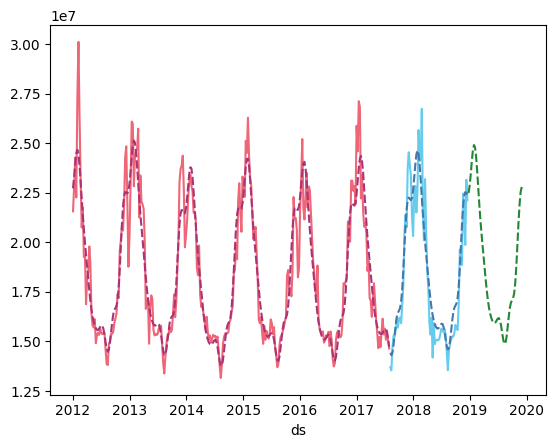

In [212]:
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
m = NeuralProphet(seasonality_mode="additive", quantiles=[0.05,0.95], collect_metrics=metrics_wanted)
metrics = m.fit(train)
predicted = m.predict(train)
forecast = m.predict(test)
future = m.make_future_dataframe(test, periods=52)
forecast2 = m.predict(future)


sns.lineplot(predicted.loc[:,['ds', 'y', 'yhat1']].set_index(keys='ds'), palette=['#EE6677', '#AA3377'], legend=False)
sns.lineplot(forecast.loc[:,['ds', 'y', 'yhat1']].set_index(keys='ds'), palette=['#66CCEE', '#4477AA'], legend=False)
sns.lineplot(forecast2.loc[:,['ds', 'y', 'yhat1']].set_index(keys='ds'), palette=['#CCBB44', '#228833'], legend=False)
plt.show()


In [215]:
# PERFORMANCE
#aller voir : https://facebook.github.io/prophet/docs/diagnostics.html 

# horizon = nb of point of val_df of each cross val
horizon = [4, 12, 24, 48, 52] #in weeks


index_max_train = len(train)-np.max(horizon)
sub_train = train.iloc[:index_max_train]
metrics_wanted={"MAPE": MeanAbsolutePercentageError(),"SMAPE":SymmetricMeanAbsolutePercentageError(),  "MAE":MeanAbsoluteError(), "RMSE":MeanSquaredError(squared=True)}
m = NeuralProphet(seasonality_mode="additive", quantiles=[0.05,0.95], collect_metrics=metrics_wanted)
metrics = m.fit(sub_train)
metrics_train = metrics.iloc[-1].T


metrics_performance = pd.DataFrame()

for horizon_current in horizon :
    index_max_val =index_max_train+horizon_current
    sub_val = train.iloc[index_max_train:index_max_val]
    # print(len(sub_val))
    metrics_val = m.test(sub_val)
    metrics_val_row = pd.DataFrame(metrics_val.iloc[-1]).T.assign(horizon=f'{len(sub_val)} weeks')

    metrics_performance = pd.concat([metrics_performance, metrics_val_row], axis=0)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.583% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 334
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (15) is too small than the required number for the learning rate finder (213). The re

Finding best initial lr:   0%|          | 0/213 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 75.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


Testing: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 91.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0026938333176076412
         MAE_val                 611370.5
        MAPE_val           0.040727950632572174
        RMSE_val              570716192768.0
      RegLoss_test                  0.0
        SMAPE_val          0.041849806904792786
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 95.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.00404620124027133
         MAE_val                777669.1875
        MAPE_val            0.0475439578294754
        RMSE_val              878934818816.0
      RegLoss_test                  0.0
        SMAPE_val          0.048616472631692886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 97.917% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0160285085439682
         MAE_val                1326823.125
        MAPE_val            0.0631214901804924
        RMSE_val              3034063044608.0
      RegLoss_test                  0.0
        SMAPE_val           0.06577631086111069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.077% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-SUN


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01220132689923048
         MAE_val                1183158.25
        MAPE_val           0.058823954313993454
        RMSE_val              2378153852928.0
      RegLoss_test                  0.0
        SMAPE_val           0.05963107571005821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.011294354684650898
         MAE_val                1105658.625
        MAPE_val            0.05518607422709465
        RMSE_val              2198903586816.0
      RegLoss_test                  0.0
        SMAPE_val          0.055930256843566895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [216]:
metrics_performance

,MAE_val,MAPE_val,RMSE_val,SMAPE_val,Loss_test,RegLoss_test,horizon
0,6.113705e+05,0.040728,5.707162e+11,0.041850,0.002694,0.0,4 weeks
0,7.776692e+05,0.047544,8.789348e+11,0.048616,0.004046,0.0,12 weeks
0,1.326823e+06,0.063121,3.034063e+12,0.065776,0.016029,0.0,24 weeks
0,1.183158e+06,0.058824,2.378154e+12,0.059631,0.012201,0.0,48 weeks
0,1.105659e+06,0.055186,2.198904e+12,0.055930,0.011294,0.0,52 weeks


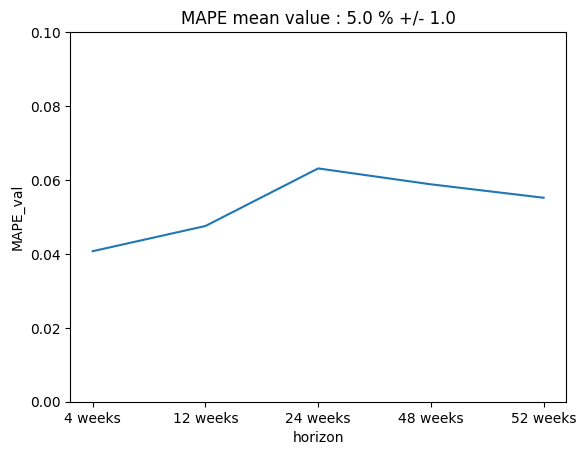

In [218]:
mean_mape_all_horizons = metrics_performance.MAPE_val.mean()
std_mape_all_horizons =  metrics_performance.MAPE_val.std()
sns.lineplot(x=metrics_performance.horizon, y=metrics_performance.MAPE_val)
plt.title(f'MAPE mean value : {round(mean_mape_all_horizons,2)*100} % +/- {round(std_mape_all_horizons,2)*100}')
plt.ylim(0, 0.1)
plt.show()